In [1]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("data/data_imputed_2.csv")

In [4]:
df.head()

,timestamp_local,temp,city_name,country_code,aqi,co,no2,o3,pm10,pm25,so2
0,01/02/2022 0:00,12.6,Gujrāt,PK,385,1339.8,76.0,10.7,491.7,347.67,238.0
1,01/02/2022 1:00,11.5,Gujrāt,PK,404,1437.6,76.0,9.3,508.3,359.33,268.0
2,01/02/2022 2:00,11.9,Gujrāt,PK,421,1535.5,76.0,8.0,525.0,371.00,298.0
3,01/02/2022 3:00,12.2,Gujrāt,PK,425,1659.0,68.3,5.3,529.3,374.00,275.7
4,01/02/2022 4:00,11.9,Gujrāt,PK,430,1782.5,60.7,2.7,533.7,377.00,253.3


In [10]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(data):
  # Visual inspection
  data.plot(figsize=(12, 6))  # Adjust figure size as needed

  # Check for trend and seasonality
  print("Look for trends or seasonality in the plot.")

  print("Performing Augmented Dickey-Fuller Test:")
  dftest = adfuller(data)
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#lags used','number of observations used'])
  for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key] = value
  print(dfoutput)

  # Interpret ADF test results
  if dftest[0] < dftest[4]['1%']:
    print("Reject null hypothesis (p-value <= 0.01). The data is likely stationary.")
    return True
  elif dftest[0] < dftest[4]['5%']:
    print("Reject null hypothesis (p-value <= 0.05). The data is likely stationary.")
    return True
  else:
    print("Fail to reject null hypothesis (p-value > 0.05). The data is likely non-stationary.")
    return False

Look for trends or seasonality in the plot.
Performing Augmented Dickey-Fuller Test:
Test Statistic                    -2.631051
p-value                            0.086748
#lags used                        44.000000
number of observations used    19661.000000
critical value (1%)               -3.430683
critical value (5%)               -2.861687
critical value (10%)              -2.566848
dtype: float64
Fail to reject null hypothesis (p-value > 0.05). The data is likely non-stationary.


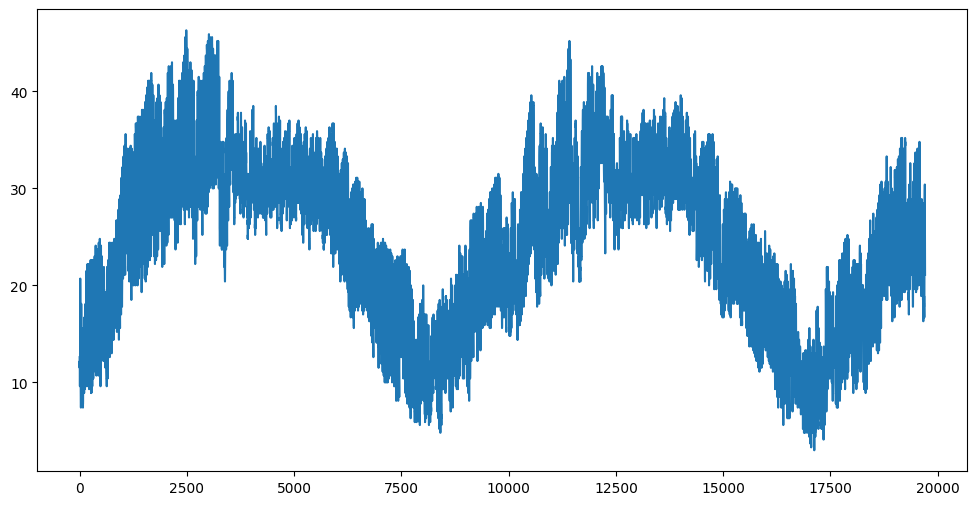

In [9]:
is_stationary = check_stationarity(df['temp'])

In [14]:
def remove_stationarity(data, method="differencing"):
  if method == "differencing":
    # Differencing (remove trend)
    differenced_data = data.diff(periods=1)  # Adjust period for differencing if needed
    print("Differencing applied (taking difference between consecutive values).")
    return differenced_data
  elif method == "detrending":
    from statsmodels.api import OLS
    # Fit a linear trend
    x = pd.Series(range(len(data)))  # Assuming data has an index
    y = data
    model = OLS(y, x).fit()
    trend = model.params[0] * x + model.params[1]

    # Detrend data by subtracting the trend
    detrended_data = data - trend
    return detrended_data
  elif method == "log transformation":
    # Log transformation (stabilize variance)
    transformed_data = np.log(data)  # Consider handling zeros appropriately
    print("Log transformation applied (taking the logarithm).")
    return transformed_data
  else:
    print(f"Method '{method}' not implemented. Choose from 'differencing', 'detrending', or 'log transformation'.")
    return data

Differencing applied (taking difference between consecutive values).


<Axes: >

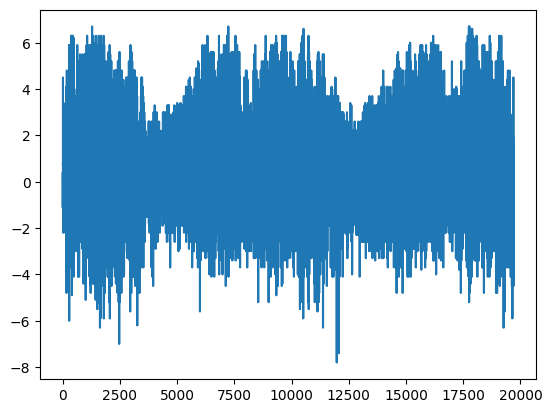

In [12]:
transformed_data = remove_stationarity(df['temp'], method="differencing")  # Use appropriate method
transformed_data.plot()

Log transformation applied (taking the logarithm).


<Axes: >

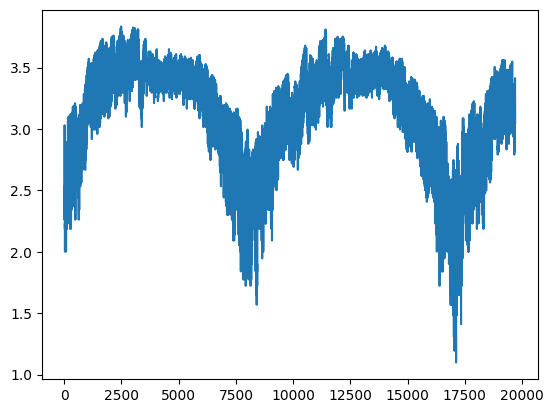

In [16]:
transformed_data = remove_stationarity(df['temp'], method="log transformation")  # Use appropriate method
transformed_data.plot()

Look for trends or seasonality in the plot.
Performing Augmented Dickey-Fuller Test:
Test Statistic                    -2.435111
p-value                            0.132071
#lags used                        45.000000
number of observations used    19660.000000
critical value (1%)               -3.430683
critical value (5%)               -2.861687
critical value (10%)              -2.566848
dtype: float64
Fail to reject null hypothesis (p-value > 0.05). The data is likely non-stationary.


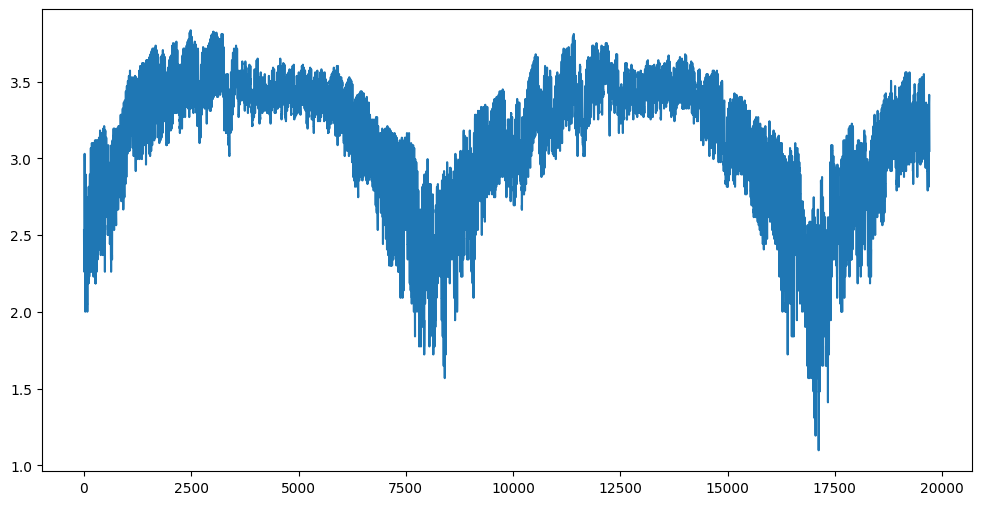

In [17]:
is_stationary = check_stationarity(transformed_data)

Differencing applied (taking difference between consecutive values).


<Axes: >

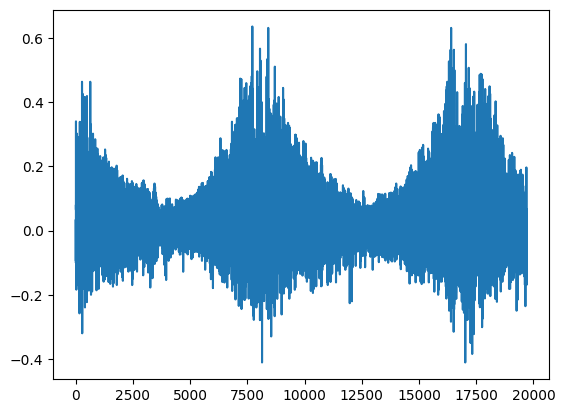

In [18]:
transformed_data = remove_stationarity(transformed_data, method="differencing")  # Use appropriate method
transformed_data.plot()

Look for trends or seasonality in the plot.
Performing Augmented Dickey-Fuller Test:
Test Statistic                   -31.421691
p-value                            0.000000
#lags used                        45.000000
number of observations used    19659.000000
critical value (1%)               -3.430683
critical value (5%)               -2.861687
critical value (10%)              -2.566848
dtype: float64
Reject null hypothesis (p-value <= 0.01). The data is likely stationary.


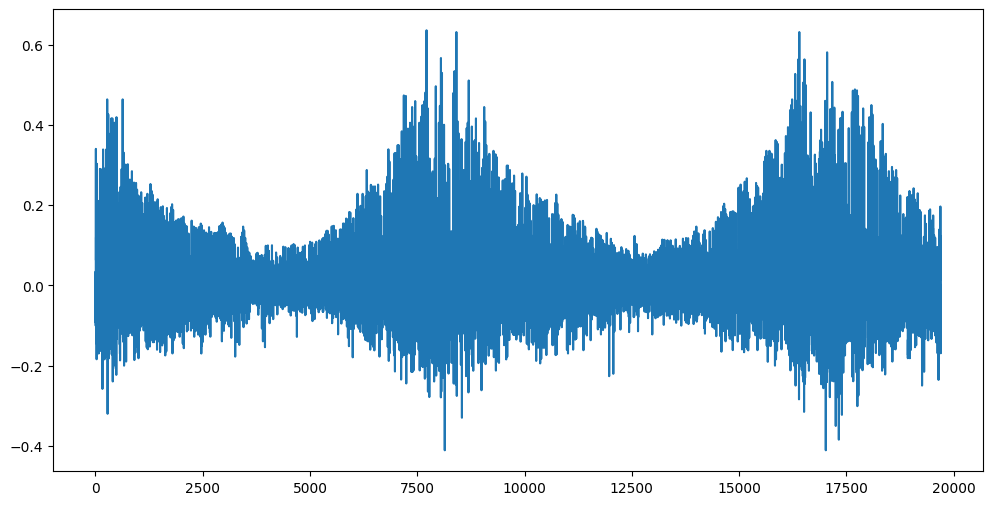

In [20]:
is_stationary = check_stationarity(transformed_data.dropna())

In [23]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(transformed_data.dropna(), lags=1)
model_fit = model.fit()
print(model_fit.summary())



                            AutoReg Model Results                             
Dep. Variable:                   temp   No. Observations:                19705
Model:                     AutoReg(1)   Log Likelihood               24842.189
Method:               Conditional MLE   S.D. of innovations              0.069
Date:                Mon, 10 Jun 2024   AIC                         -49678.379
Time:                        14:57:11   BIC                         -49654.713
Sample:                             1   HQIC                        -49670.631
                                19705                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.099e-05      0.000      0.043      0.966      -0.001       0.001
temp.L1        0.3749      0.007     56.766      0.000       0.362       0.388
                                    Roots           

C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [26]:
forecast = model_fit.forecast(steps=168)
print(f"One-step forecast: {forecast}")

One-step forecast: 19705    0.000021
19706    0.000029
19707    0.000032
19708    0.000033
19709    0.000033
           ...   
19868    0.000034
19869    0.000034
19870    0.000034
19871    0.000034
19872    0.000034
Length: 168, dtype: float64


C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [27]:
transformed_data

0             NaN
1       -0.091350
2        0.034191
3        0.024898
4       -0.024898
           ...   
19701   -0.169258
19702   -0.029108
19703   -0.029981
19704   -0.086221
19705    0.000000
Name: temp, Length: 19706, dtype: float64

In [29]:
def retransform_predictions(predictions, original_data):
  """
  This function retransforms predictions from a log-differenced AR model 
  to get the actual predictions in the original scale.

  Args:
      predictions (np.ndarray): The predicted values from the model (log-differenced).
      original_data (pd.Series): The original time series data (before transformation).

  Returns:
      np.ndarray: The retransformed predictions in the original scale.
  """

  # Apply inverse differencing
  differenced_data = original_data.diff(periods=1).dropna()  # Assuming differenced by 1
  inverse_differenced = differenced_data.cumsum() + original_data[0]  # Restore starting value

  # Apply inverse log transformation (assuming log10)
  predictions = np.exp(predictions)

  # Add inverse differencing to predictions (assuming predictions start after differencing)
  retransformed_predictions = predictions + inverse_differenced[predictions.shape[0]:]

  return retransformed_predictions

# Example usage (assuming you have the fitted model and original data)
predicted_log_diffs = model_fit.forecast(steps=168)
retransformed_predictions = retransform_predictions(predicted_log_diffs, df['temp'])

C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [30]:
retransformed_predictions

169     NaN
170     NaN
171     NaN
172     NaN
173     NaN
         ..
19868   NaN
19869   NaN
19870   NaN
19871   NaN
19872   NaN
Length: 19704, dtype: float64

In [33]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Example time series data
data = df['temp']

# Split data into training and test sets
train_size = int(len(data) * 0.8)  # 80% for training, 20% for testing
train, test = data[:train_size], data[train_size:]

# Differencing to make the training series stationary
train_diff = train.diff().dropna()

# Check stationarity of differenced training data
result_diff = adfuller(train_diff)
print('ADF Statistic (differenced):', result_diff[0])
print('p-value (differenced):', result_diff[1])

# Fit ARIMA model on differenced training data
model = ARIMA(train_diff, order=(1, 0, 0))
model_fit = model.fit()

# Forecasting for the test period
forecast_diff = model_fit.forecast(steps=len(test))
print('Differenced Forecast:', forecast_diff)

# Invert differencing to get forecasts in original scale
last_train_value = train.iloc[-1]
forecast = np.cumsum(np.concatenate([[last_train_value], forecast_diff]))[1:]
print('Forecast in original scale:', forecast)

# Evaluate forecast performance
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast)
print('RMSE:', rmse)
print('MAPE:', mape)

ADF Statistic (differenced): -27.074063775485747
p-value (differenced): 0.0


C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Differenced Forecast: 15763   -0.436353
15764   -0.172864
15765   -0.068249
15766   -0.026714
15767   -0.010223
           ...   
19700    0.000636
19701    0.000636
19702    0.000636
19703    0.000636
19704    0.000636
Name: predicted_mean, Length: 3942, dtype: float64
Forecast in original scale: [22.56364655 22.39078295 22.32253363 ... 24.77990404 24.78053973
 24.78117543]
RMSE: 9.367655636676913
MAPE: 0.7404105503246556


C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
